# Kaiser–Bessel Kernel: Mathematical Definitions

## Kaiser–Bessel Function
The Kaiser–Bessel kernel is defined as:

$$K(x) = \frac{I_0(\beta \sqrt{1 - \left(\frac{2x}{W}\right)^2})}{I_0(\beta)}$$

where:
- $x$ is the input coordinate (typically $x \in [0, 1]$ for normalized domain)
- $W = w \cdot \sigma$ is the kernel support width
- $w$ is the kernel width parameter (default: 16)
- $\sigma$ is the oversampling factor (default: 2)
- $\beta = \pi w \left(1 - \frac{1}{2\sigma}\right)$ is the shape parameter
- $I_0(z)$ is the modified Bessel function of the first kind, order 0

## Modified Bessel Function $I_0(z)$
The modified Bessel function of the first kind, order 0, can be computed using:

**For small arguments** ($|z| \leq 15$):
$$I_0(z) = \sum_{k=0}^{\infty} \frac{1}{(k!)^2} \left(\frac{z^2}{4}\right)^k$$

**For large arguments** ($|z| > 15$):
$$I_0(z) \approx \frac{e^{|z|}}{\sqrt{2\pi |z|}} \sum_{k=0}^{\infty} \frac{(-1)^k (2k-1)!!^2}{k! (8|z|)^k}$$

## Domain and Properties
- Input domain: $x \in [0, 1]$ (normalized)  
- The kernel is symmetric: $K(-x) = K(x)$
- Maximum value at $x = 0$: $K(0) = 1$
- Approaches zero as $|x| \to 1$

In [1]:
# --- Setup ---
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numba
import cppyy
from numpy.polynomial import Chebyshev as Ch
import scipy

# Global parameters
w = 1.5
sigma = 2.0
W = w * sigma
a, b = 0.0, 1.0   # domain for plotting and benchmarking

# Benchmark size
N = 100_000

# Reproducibility
rng = np.random.default_rng(42)
dx_bench = rng.uniform(a, b, size=N)  # fixed samples for fair comparisons

# Plot grid
dx_plot = np.linspace(a, b, 1000)

In [2]:
# --- Utilities ---

def benchmark_func(func, name, elems, warmup=None):
    """
    func: callable (scalar function)
    name: str
    elems: iterable of scalars
    warmup: optional callable to warm up JITs (e.g., numba) before timing.
    """
    if warmup is not None:
        warmup()

    t0 = time.perf_counter()
    # Always use list comprehension for scalar evaluation
    y = [func(x) for x in elems]
    t1 = time.perf_counter()

    N = len(elems)
    total_time = t1 - t0
    return {
        "method": name,
        "N": N,
        "seconds": total_time,
        "M evals/s": (N / total_time) / 1e6,
        "checksum": float(np.sum(y))
    }


def add_relative_speedup(df, baseline="numpy"):
    df = df.copy()
    # throughput proportional to "M evals/s"
    base = df.loc[df["method"] == baseline, "M evals/s"]
    if len(base) == 0:
        df["speedup_vs_numpy"] = np.nan
        return df
    base = float(base.iloc[0])
    df["speedup_vs_numpy"] = df["M evals/s"] / base
    return df


def plot_overlay(curves, title="Kaiser–Bessel kernel", xlabel="dx", ylabel="value"):
    plt.figure()
    for y, label in curves:
        plt.plot(dx_plot, y, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title + f" (w={w:.1f}, sigma={sigma:.1f})")
    plt.legend()
    plt.show()

## Method 1: NumPy (plain, scalar)
Scalar implementation using `numpy` operations and `np.i0`.

In [3]:
# Method 1: NumPy (scalar only)
def kaiser_bessel_numpy(dx):
    """
    Scalar Kaiser-Bessel function using NumPy functions.
    dx: scalar value
    Uses global parameters w and sigma.
    """
    W = w * sigma
    a = (2.0 * dx) / W
    beta = np.pi * w * (1.0 - 1.0 / (2.0 * sigma))
    # clamp the inner sqrt to avoid negative due to fp error
    inside = 1.0 - a*a
    inside = max(0.0, inside)
    t = np.sqrt(inside)
    return float(np.i0(beta * t) / np.i0(beta))

## Plot: Method 1

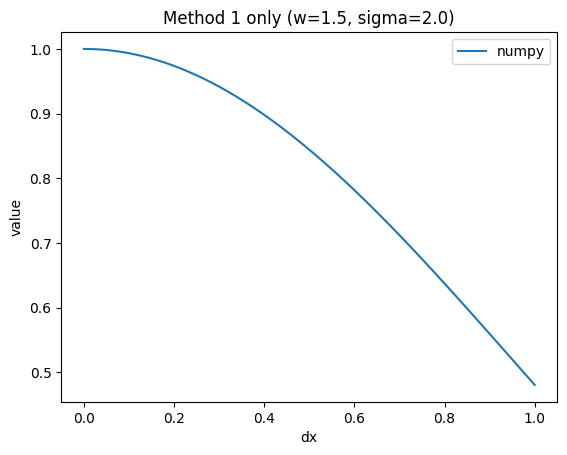

In [4]:
# Use list comprehension for scalar evaluation
y1 = [kaiser_bessel_numpy(x) for x in dx_plot]
plot_overlay([(y1, "numpy")], title="Method 1 only")

## Benchmark: Method 1

In [5]:
results = []
results.append(benchmark_func(lambda x: kaiser_bessel_numpy(x),
                              "numpy", dx_bench))
df = pd.DataFrame(results)
display(df)

,method,N,seconds,M evals/s,checksum
0,numpy,100000,8.490756,0.011778,80855.205152


## Method 2: C++ via `cppyy`

Scalar implementation using C++ code compiled at runtime via cppyy.
Uses the standard library's modified Bessel function.

In [6]:
cppyy.cppdef(r'''
#pragma GCC optimize ("O3")
#pragma GCC target("native")

#include <cmath>

inline double kaiser_bessel(double dx, double w, double sigma) {
    const double W = w * sigma;
    const double a = (2.0 * dx) / W;
    constexpr double pi = 3.14159265358979323846;
    const double beta = pi * w * (1.0 - 1.0 / (2.0 * sigma));
    const double inside = 1.0 - a * a;
    const double t = std::sqrt(inside);
    return std::cyl_bessel_i(0.0, beta * t) / std::cyl_bessel_i(0.0, beta);
}
''')

def kaiser_bessel_cpp(x):
    """
    Scalar Kaiser-Bessel function using C++ via cppyy.
    x: scalar value
    Uses global parameters w and sigma.
    """
    return float(cppyy.gbl.kaiser_bessel(float(x), float(w), float(sigma)))

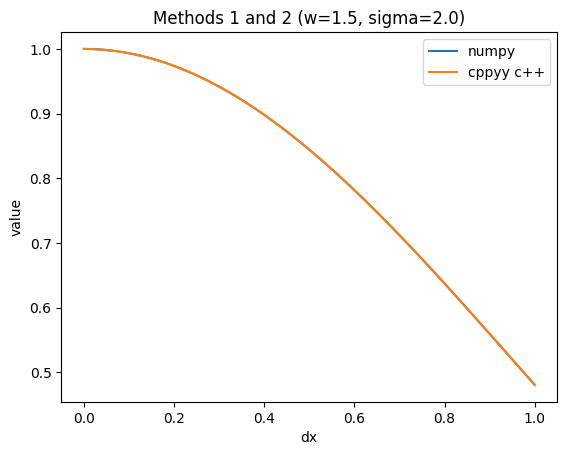

In [7]:
curves = [(y1, "numpy")]
y2 = [kaiser_bessel_cpp(x) for x in dx_plot]
curves.append((y2, "cppyy c++"))
plot_overlay(curves, title="Methods 1 and 2")

In [8]:
# Accumulate results
results.append(benchmark_func(lambda x: kaiser_bessel_cpp(x),
                                "cppyy c++", dx_bench))

df = pd.DataFrame(results)
df = add_relative_speedup(df, baseline="numpy")
display(df)

,method,N,seconds,M evals/s,checksum,speedup_vs_numpy
0,numpy,100000,8.490756,0.011778,80855.205152,1.00000
1,cppyy c++,100000,0.072167,1.385668,80855.205152,117.65368


## Method 3: `@numba.njit`
Scalar `i0` and kernel using Numba JIT compilation for performance.
If Numba is unavailable, this section will skip.

In [9]:
@numba.njit
def kaiser_bessel_jit(dx, w_val, sigma_val):
    """
    Scalar Kaiser-Bessel function using Numba JIT with direct C++ Bessel function integration.
    dx: scalar value
    w_val, sigma_val: parameters passed from global values
    """
    W = w_val * sigma_val
    a = (2.0 * dx) / W
    beta = math.pi * w_val * (1.0 - 1.0 / (2.0 * sigma_val))
    inside = 1.0 - a * a
    if inside < 0.0:
        inside = 0.0
    t = math.sqrt(inside)
    
    # Direct call to C++ function - cppyy.numba_ext makes this work seamlessly!
    return np.i0(beta * t) / np.i0(beta)

def _numba_warmup():
    # warm up compilation
    _ = kaiser_bessel_jit(0.0, w, sigma)
    _ = kaiser_bessel_jit(0.5, w, sigma)
    _ = kaiser_bessel_jit(1.0, w, sigma)
print("Numba + C++ integration ready!")


Numba + C++ integration ready!


In [10]:
try:
    _numba_warmup()

except Exception as e:
    print("NUMBA compilation failed!")
    print(e)

NUMBA compilation failed!
Failed in nopython mode pipeline (step: nopython frontend)
Use of unsupported NumPy function 'numpy.i0' or unsupported use of the function.

File "../../../../tmp/ipykernel_128079/1896978236.py", line 17:
<source missing, REPL/exec in use?>

During: typing of get attribute at /tmp/ipykernel_128079/1896978236.py (17)

File "../../../../tmp/ipykernel_128079/1896978236.py", line 17:
<source missing, REPL/exec in use?>

During: Pass nopython_type_inference


In [11]:
# Import cppyy numba extension for seamless integration
import cppyy.numba_ext

# Define C++ Bessel function using cppyy
cppyy.cppdef(r'''
#include <cmath>
double i0(double x) {
    return std::cyl_bessel_i(0.0, x);
}
''')

@numba.njit
def kaiser_bessel_jit(dx, w_val, sigma_val):
    """
    Scalar Kaiser-Bessel function using Numba JIT with direct C++ Bessel function integration.
    dx: scalar value
    w_val, sigma_val: parameters passed from global values
    """
    W = w_val * sigma_val
    a = (2.0 * dx) / W
    beta = math.pi * w_val * (1.0 - 1.0 / (2.0 * sigma_val))
    inside = 1.0 - a * a
    if inside < 0.0:
        inside = 0.0
    t = math.sqrt(inside)

    # Direct call to C++ function - cppyy.numba_ext makes this work seamlessly!
    return cppyy.gbl.i0(beta * t) / cppyy.gbl.i0(beta)

def _numba_warmup():
    # warm up compilation
    _ = kaiser_bessel_jit(0.0, w, sigma)
    _ = kaiser_bessel_jit(0.5, w, sigma)
    _ = kaiser_bessel_jit(1.0, w, sigma)

print("Numba + C++ integration ready!")
_numba_warmup()

Numba + C++ integration ready!


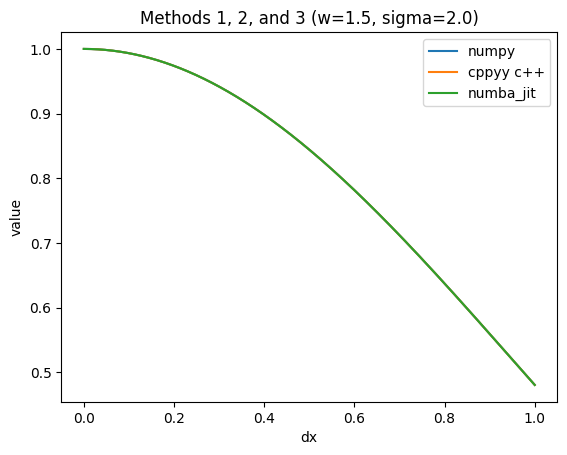

In [12]:
curves = [(y1, "numpy")]
y2 = [kaiser_bessel_cpp(x) for x in dx_plot]
curves.append((y2, "cppyy c++"))
y3 = [kaiser_bessel_jit(x, w, sigma) for x in dx_plot]
curves.append((y3, "numba_jit"))

plot_overlay(curves, title="Methods 1, 2, and 3")

In [13]:
results.append(benchmark_func(lambda x: kaiser_bessel_jit(x, w, sigma),
                                "numba_jit", dx_bench, warmup=_numba_warmup))

df = pd.DataFrame(results)
df = add_relative_speedup(df, baseline="numpy")
display(df)

,method,N,seconds,M evals/s,checksum,speedup_vs_numpy
0,numpy,100000,8.490756,0.011778,80855.205152,1.00000
1,cppyy c++,100000,0.072167,1.385668,80855.205152,117.65368
2,numba_jit,100000,0.073285,1.364531,80855.205152,115.85902


## Method 4: NumPy Chebyshev fit
Chebyshev fit on `[0, 1]` with degree 16

In [14]:
def kaiser_bessel_poly(deg=16, samples=4097, domain=(0.0, 1.0)):
    """
    Fit Chebyshev polynomial to kaiser_bessel on [domain[0], domain[1]].
    Returns a numpy.polynomial.Chebyshev object that can be called on scalars.
    Uses global parameters w and sigma.
    """
    x = np.linspace(domain[0], domain[1], samples)
    y = [kaiser_bessel_numpy(xi) for xi in x]
    return Ch.fit(x, y, deg, domain=domain)

np_cheb = kaiser_bessel_poly(deg=16, samples=4097, domain=(0.0, 1.0))

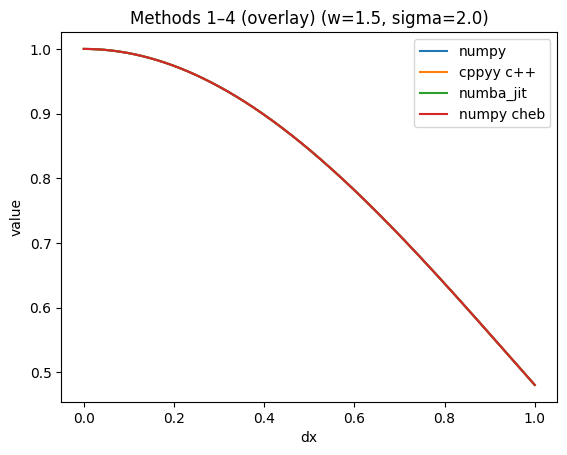

In [15]:
curves = [(y1, "numpy")]
y2 = [kaiser_bessel_cpp(x) for x in dx_plot]
curves.append((y2, "cppyy c++"))
y3 = [kaiser_bessel_jit(x, w, sigma) for x in dx_plot]
curves.append((y3, "numba_jit"))

y4 = [np_cheb(x) for x in dx_plot]
curves.append((y4, "numpy cheb"))

plot_overlay(curves, title="Methods 1–4 (overlay)")

In [16]:
results.append(benchmark_func(lambda x: np_cheb(x),
                              "numpy cheb", dx_bench))

df = pd.DataFrame(results)
df = add_relative_speedup(df, baseline="numpy")
display(df)

,method,N,seconds,M evals/s,checksum,speedup_vs_numpy
0,numpy,100000,8.490756,0.011778,80855.205152,1.000000
1,cppyy c++,100000,0.072167,1.385668,80855.205152,117.653680
2,numba_jit,100000,0.073285,1.364531,80855.205152,115.859020
3,numpy cheb,100000,0.411826,0.242821,80855.205152,20.617361


## Method 5: C++ Chebyshev via `cppyy`
Uses a simple Chebyshev class in C++ that maps `[0, 1]` to `[-1, 1]` internally.
If `cppyy` is not installed, this section will skip.

In [17]:
cppyy.cppdef(r'''
#pragma GCC optimize ("O3", "unroll-loops")
#pragma GCC target("native")

#include <vector>
#include <algorithm>
#include <functional>
#include <cmath>
#include <type_traits>

#define ALWAYS_INLINE inline __attribute__((always_inline))

using InputType = double;

constexpr double PI = 3.14159265358979323846;

template <class Func> class Cheb {
public:
    Cheb(Func F, const int n, const InputType a = -1, const InputType b = 1)
        : nodes(n), low(InputType(1) / (b - a)), hi(b + a), coeffs(nodes) {

        std::vector<double> fvals(nodes);

        for (int k = 0; k < nodes; ++k) {
            double theta = (2 * k + 1) * PI / (2 * nodes);
            double xk = std::cos(theta);
            double x_mapped = map_to_domain(xk);
            fvals[k] = F(x_mapped);
        }

        for (int m = 0; m < nodes; ++m) {
            double sum = 0.0;
            for (int k = 0; k < nodes; ++k) {
                double theta = (2 * k + 1) * PI / (2 * nodes);
                sum += fvals[k] * std::cos(m * theta);
            }
            coeffs[m] = (2.0 / nodes) * sum;
        }

        coeffs[0] *= 0.5;
        std::reverse(coeffs.begin(), coeffs.end());
    }

#pragma GCC push_options
#pragma GCC optimize ("fast-math")
    ALWAYS_INLINE constexpr double operator()(const double pt) const {
        const double x = map_from_domain(pt);
        const double x2 = 2 * x;

        double c0 = coeffs[0];
        double c1 = coeffs[1];
        for (int i = 2; i < nodes; ++i) {
            const double tmp = c1;
            c1 = coeffs[i] - c0;
            c0 = std::fma(c0, x2, tmp);
        }
        return std::fma(c0, x, c1);
    }
#pragma GCC pop_options

private:
    const int nodes;
    InputType low, hi;
    std::vector<double> coeffs;

    // Updated mapping functions based on your FuncEval implementation
    template <class T>
    ALWAYS_INLINE constexpr T map_to_domain(const T T_arg) const noexcept {
        return static_cast<T>(0.5 * (T_arg / low + hi));
    }
#pragma GCC push_options
#pragma GCC optimize ("fast-math")
    template <class T>
    ALWAYS_INLINE constexpr T map_from_domain(const T T_arg) const noexcept {
        return static_cast<T>(std::fma(2.0, T_arg, -T(hi)) * low);
    }
#pragma GCC pop_options

};

using ChebFn = Cheb<std::function<double(double)>>;

inline ChebFn make_cheb(std::function<double(double)> f, int n, double a=-1.0, double b=1.0) {
    return ChebFn(std::move(f), n, a, b);
}
''')

# Build the Chebyshev approximant for kaiser_bessel using the NumPy reference
ChebFn = cppyy.gbl.ChebFn
make_cheb = cppyy.gbl.make_cheb
kaiser_bessel_cheb_cpp = make_cheb(lambda x: kaiser_bessel_numpy(x), 16, 0.0, 1.0)

def kaiser_bessel_cheb(x):
    """
    Scalar Kaiser-Bessel function using C++ Chebyshev approximation.
    x: scalar value
    Uses global parameters w and sigma via the fitted approximant.
    """
    return float(kaiser_bessel_cheb_cpp(x))

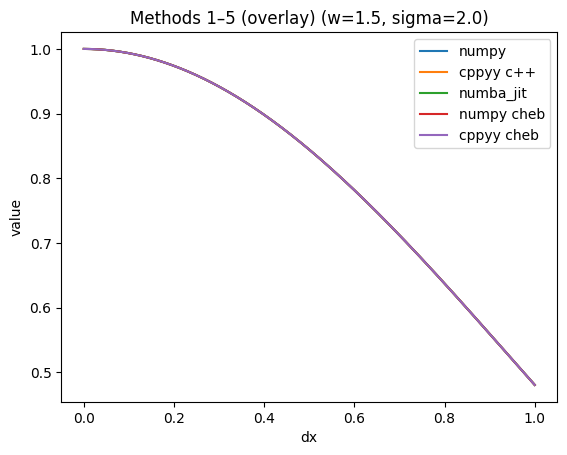

In [18]:
curves = [(y1, "numpy")]
y2 = [kaiser_bessel_cpp(x) for x in dx_plot]
curves.append((y2, "cppyy c++"))
y3 = [kaiser_bessel_jit(x, w, sigma) for x in dx_plot]
curves.append((y3, "numba_jit"))
y4 = [np_cheb(x) for x in dx_plot]
curves.append((y4, "numpy cheb"))
y5 = [kaiser_bessel_cheb(x) for x in dx_plot]
curves.append((y5, "cppyy cheb"))

plot_overlay(curves, title="Methods 1–5 (overlay)")

## Benchmark: Methods 1–5 with speedup

,method,N,seconds,M evals/s,checksum,speedup_vs_numpy
0,numpy,100000,8.490756,0.011778,80855.205152,1.000000
1,cppyy c++,100000,0.072167,1.385668,80855.205152,117.653680
2,numba_jit,100000,0.073285,1.364531,80855.205152,115.859020
3,numpy cheb,100000,0.411826,0.242821,80855.205152,20.617361
4,cppyy cheb,100000,0.015506,6.449253,80855.205152,547.590384


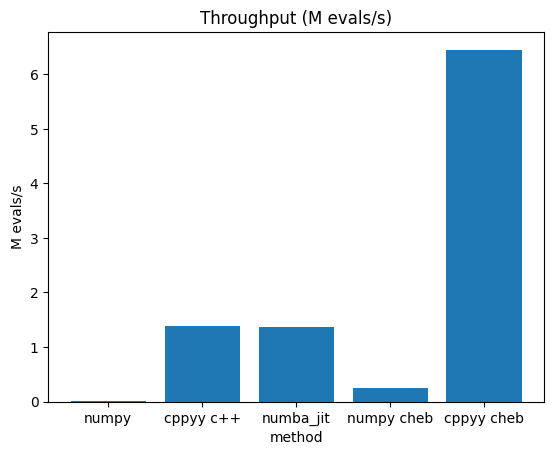

In [19]:
results.append(benchmark_func(lambda x: kaiser_bessel_cheb(x), "cppyy cheb", dx_bench))

df = pd.DataFrame(results)
df = add_relative_speedup(df, baseline="numpy")
# Reorder rows to the requested method order if present
order = ["numpy", "cppyy c++", "numba_jit", "numpy cheb", "cppyy cheb"]
df["order_idx"] = df["method"].apply(lambda m: order.index(m) if m in order else 999)
df = df.sort_values(["order_idx"]).drop(columns=["order_idx"]).reset_index(drop=True)
display(df)

# Optional: simple throughput bar
plt.figure()
plt.bar(df["method"], df["M evals/s"])
plt.title("Throughput (M evals/s)")
plt.ylabel("M evals/s")
plt.xlabel("method")
plt.show()

# Steady Diffusion in a Cylinder with Surface Reaction

## Physical System

The model describes **gas diffusion into a catalyst pellet** - a classic problem in chemical engineering and catalysis. Imagine a cylindrical porous catalyst particle immersed in a gas containing reactant molecules.

## Mathematical Model

### Governing Equation
Inside the cylinder, concentration obeys the **steady-state diffusion equation**:

$$\nabla^2 C = \frac{1}{r}\frac{d}{dr}\left(r\frac{dC}{dr}\right) = 0$$

This simplifies to the **modified Bessel equation** when we introduce a length scale $L$:

$$\frac{d^2C}{dr^2} + \frac{1}{r}\frac{dC}{dr} - \frac{1}{L^2}C = 0$$

### Boundary Conditions

1. **Center (r=0)**: Symmetry condition
   $$\frac{dC}{dr}\bigg|_{r=0} = 0$$

2. **Surface (r=R)**: **Coupled reaction-diffusion boundary condition**
   $$-D\frac{dC}{dr}\bigg|_{r=R} = k_s(C_s - C(R))$$
   
   This says: *diffusive flux into surface = reaction rate at surface*

## Analytical Solution

The solution involves **modified Bessel functions** I₀ and I₁:

$$C(r) = C_s \frac{I_0(r/L)}{I_0(R/L) + \frac{k_s L}{D} I_1(R/L)}$$

### Physical Parameters

- **R = 1 mm**: Cylinder radius (particle size)
- **L = 0.5 mm**: Diffusion length scale $L = \sqrt{D/k_r}$ where $k_r$ is reaction rate
- **D = 10⁻⁹ m²/s**: Diffusion coefficient (typical for gases in porous media)
- **k_s = 2×10⁻⁴ m/s**: Surface reaction rate constant
- **C_s = 1.0 mol/m³**: Bulk gas concentration at surface

## Physical Interpretation

### Dimensionless Groups

1. **Thiele modulus**: $\phi = R/L = 2$
   - Measures competition between reaction and diffusion
   - $\phi > 1$ means **diffusion-limited** regime

2. **Biot number**: $Bi = k_s L/D = 0.1$
   - Measures external mass transfer resistance
   - $Bi \ll 1$ means **surface reaction-limited**

### Concentration Profile

The solution shows:
- **Maximum concentration** at center (r=0)
- **Decreases toward surface** due to diffusion + reaction
- **Effectiveness factor** η = C(0)/C_s ≈ 0.8 (80% of theoretical maximum)

This indicates the catalyst is **reasonably effective** but diffusion limitations reduce performance by ~20%.

In [20]:
# Example: Steady diffusion in a cylinder with surface reaction
# Physical problem: gas uptake in a catalyst pellet

# Problem parameters
R = 1e-3      # Cylinder radius (m)
L_diff = 0.5e-3  # Diffusion length scale (m)
D = 1e-9      # Diffusion coefficient (m²/s)
k_s = 2e-4    # Surface reaction rate constant (m/s)
C_s = 1.1     # Surface concentration (mol/m³)

# Spatial grid
n_points = 10_000_000  
r_array = np.linspace(0, R, n_points)

print(f"Problem: Steady diffusion in cylinder with surface reaction")
print(f"Cylinder radius R = {R*1e3:.2f} mm")
print(f"Diffusion length L = {L_diff*1e3:.3f} mm")
print(f"Number of evaluation points: {n_points:,}")
print(f"Modified Bessel functions I₀ and I₁ required")

Problem: Steady diffusion in cylinder with surface reaction
Cylinder radius R = 1.00 mm
Diffusion length L = 0.500 mm
Number of evaluation points: 10,000,000
Modified Bessel functions I₀ and I₁ required


In [21]:
def steady_diffusion_cylinder(r, R, L, D, k_s, C_s):
    """
    Steady diffusion in a cylinder with surface reaction.
    No fast primitive exists for the coupled boundary condition.
    
    Solves: ∇²C = 0 in cylinder with boundary condition:
    -D(∂C/∂r)|_{r=R} = k_s(C_s - C(R))
    
    Parameters
    ----------
    r : array_like
        Radial positions (m)
    R : float
        Cylinder radius (m)
    L : float
        Diffusion length scale (m)
    D : float
        Diffusion coefficient (m²/s)
    k_s : float
        Surface reaction rate constant (m/s)
    C_s : float
        Surface concentration (mol/m³)
        
    Returns
    -------
    C : ndarray
        Concentration profile
    """
    from scipy.special import i0, i1
    
    num = i0(r / L)
    denom = i0(R / L) + (k_s * L / D) * i1(R / L)
    return C_s * num / denom

In [22]:
# Benchmark the NumPy/SciPy baseline
start = time.perf_counter()
C = steady_diffusion_cylinder(r_array, R, L_diff, D, k_s, C_s)
elapsed = time.perf_counter() - start
print(f"steady_diffusion_cylinder took {elapsed:.6f} seconds")
print(f"Throughput: {n_points/elapsed/1e6:.2f} M evals/s")


steady_diffusion_cylinder took 0.334453 seconds
Throughput: 29.90 M evals/s


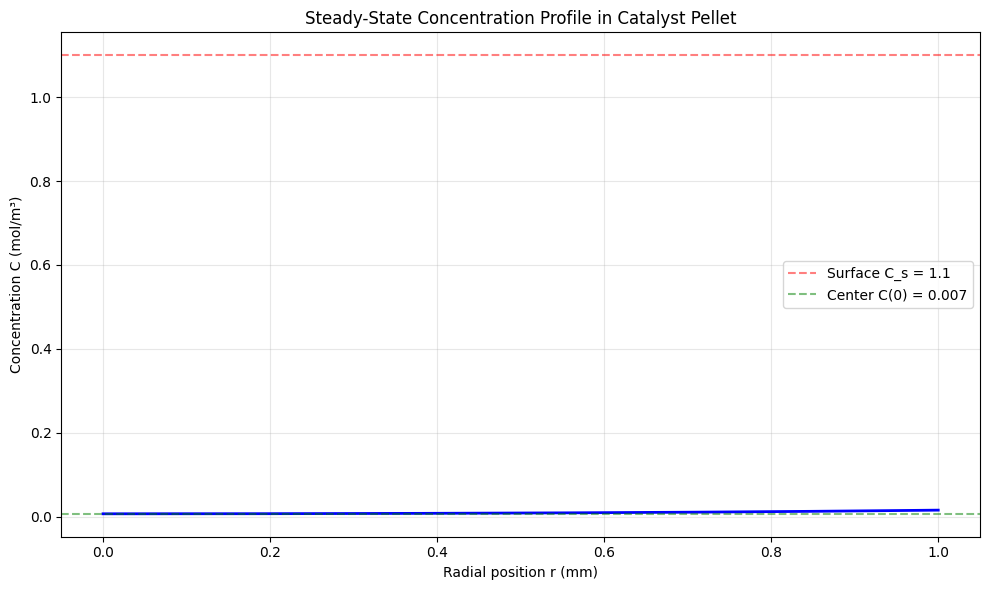


Concentration profile statistics:
  Surface concentration C(R): 0.0155 mol/m³
  Center concentration C(0): 0.0068 mol/m³
  Concentration drop: 56.13%
  Effectiveness factor: 0.0062


In [23]:
# Visualize the concentration profile
r_plot = np.linspace(0, R, 200)
C_plot = steady_diffusion_cylinder(r_plot, R, L_diff, D, k_s, C_s)

plt.figure(figsize=(10, 6))
plt.plot(r_plot * 1e3, C_plot, 'b-', linewidth=2)
plt.xlabel("Radial position r (mm)")
plt.ylabel("Concentration C (mol/m³)")
plt.title("Steady-State Concentration Profile in Catalyst Pellet")
plt.grid(True, alpha=0.3)
plt.axhline(y=C_s, color='r', linestyle='--', alpha=0.5, label=f'Surface C_s = {C_s}')
plt.axhline(y=C_plot[0], color='g', linestyle='--', alpha=0.5, label=f'Center C(0) = {C_plot[0]:.3f}')
plt.legend()
plt.tight_layout()
plt.show()

# Print statistics
print(f"\nConcentration profile statistics:")
print(f"  Surface concentration C(R): {C_plot[-1]:.4f} mol/m³")
print(f"  Center concentration C(0): {C_plot[0]:.4f} mol/m³")
print(f"  Concentration drop: {(1 - C_plot[0]/C_plot[-1])*100:.2f}%")
print(f"  Effectiveness factor: {C_plot[0]/C_s:.4f}")

/tmp/ipykernel_128079/1296894602.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax2.pcolormesh(X, Y, C_2d, cmap='viridis', shading='auto')


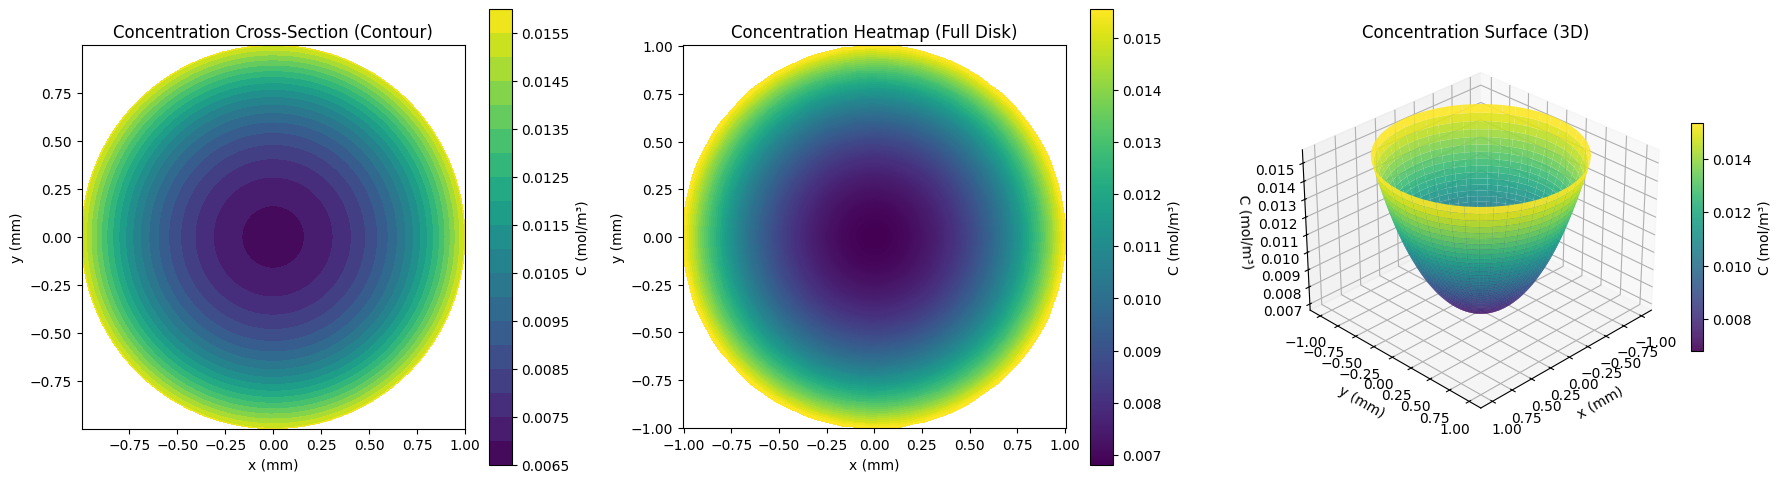


2D/3D Visualization showing radial symmetry:
  Concentration varies from C(0)=0.0068 (center)
  to C(R)=0.0155 (surface) mol/m³
  Due to circular symmetry, C only depends on radius r, not angle θ


In [24]:
# Enhanced 2D/3D visualizations showing radial symmetry
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(18, 5))

# 1. Polar contour plot (cross-section of cylinder)
ax1 = plt.subplot(131)
theta = np.linspace(0, 2*np.pi, 100)
r_2d = np.linspace(0, R, 100)
R_mesh, Theta_mesh = np.meshgrid(r_2d, theta)

# Compute concentration (only depends on r, not theta due to symmetry)
C_2d = steady_diffusion_cylinder(R_mesh.ravel(), R, L_diff, D, k_s, C_s).reshape(R_mesh.shape)

# Convert to Cartesian for plotting
X = R_mesh * np.cos(Theta_mesh) * 1e3  # convert to mm
Y = R_mesh * np.sin(Theta_mesh) * 1e3

contour = ax1.contourf(X, Y, C_2d, levels=20, cmap='viridis')
ax1.set_xlabel('x (mm)')
ax1.set_ylabel('y (mm)')
ax1.set_title('Concentration Cross-Section (Contour)')
ax1.set_aspect('equal')
plt.colorbar(contour, ax=ax1, label='C (mol/m³)')

# 2. Heatmap (full disk view)
ax2 = plt.subplot(132)
im = ax2.pcolormesh(X, Y, C_2d, cmap='viridis', shading='auto')
ax2.set_xlabel('x (mm)')
ax2.set_ylabel('y (mm)')
ax2.set_title('Concentration Heatmap (Full Disk)')
ax2.set_aspect('equal')
plt.colorbar(im, ax=ax2, label='C (mol/m³)')

# 3. 3D surface plot (showing radial symmetry)
ax3 = plt.subplot(133, projection='3d')
r_3d = np.linspace(0, R, 50)
theta_3d = np.linspace(0, 2*np.pi, 50)
R_3d, Theta_3d = np.meshgrid(r_3d, theta_3d)
C_3d = steady_diffusion_cylinder(R_3d.ravel(), R, L_diff, D, k_s, C_s).reshape(R_3d.shape)
X_3d = R_3d * np.cos(Theta_3d) * 1e3
Y_3d = R_3d * np.sin(Theta_3d) * 1e3

surf = ax3.plot_surface(X_3d, Y_3d, C_3d, cmap='viridis', 
                        linewidth=0, antialiased=True, alpha=0.9)
ax3.set_xlabel('x (mm)')
ax3.set_ylabel('y (mm)')
ax3.set_zlabel('C (mol/m³)')
ax3.set_title('Concentration Surface (3D)')
ax3.view_init(elev=30, azim=45)
plt.colorbar(surf, ax=ax3, label='C (mol/m³)', shrink=0.5)

plt.tight_layout()
plt.show()

print("\n2D/3D Visualization showing radial symmetry:")
print(f"  Concentration varies from C(0)={C_plot[0]:.4f} (center)")
print(f"  to C(R)={C_plot[-1]:.4f} (surface) mol/m³")
print(f"  Due to circular symmetry, C only depends on radius r, not angle θ")

# Exercise: Accelerating the Cylinder Diffusion Function

The `steady_diffusion_cylinder` function requires computing modified Bessel functions I₀ and I₁ for many radial positions. Let's explore acceleration strategies using the techniques we've learned.

## Current Performance Baseline

The pure NumPy/SciPy implementation evaluates Bessel functions at 100,000 points. Your task is to accelerate this computation using:

1. **Numba JIT compilation** - for automatic optimization
2. **C++ via cppyy** - for manual optimization with fast Bessel functions
3. **Chebyshev approximation** - leveraging the existing Cheb class for I₀ and I₁

## Exercise Goals

- Understand performance bottlenecks in special function evaluation
- Apply JIT compilation techniques to real scientific problems  
- Compare direct evaluation vs. polynomial approximation strategies
- Measure and analyze performance improvements

In [25]:
import cppyy.numba_ext

# Strategy: Use Chebyshev approximation for I0 and I1
# These functions are smooth and well-behaved, perfect for Chebyshev!

cppyy.cppdef(r'''
#pragma GCC optimize ("O3", "fast-math")
#pragma GCC target("native")

#include <cmath>

// Create Chebyshev approximations for I0 and I1
// Domain [0, 10] covers typical arguments for our problem
inline ChebFn make_i0_cheb(int n, double a, double b) {
    auto i0_func = [](double x) -> double {
        return std::cyl_bessel_i(0.0, x);
    };
    return ChebFn(i0_func, n, a, b);
}

inline ChebFn make_i1_cheb(int n, double a, double b) {
    auto i1_func = [](double x) -> double {
        return std::cyl_bessel_i(1.0, x);
    };
    return ChebFn(i1_func, n, a, b);
}

// Global Chebyshev approximations
ChebFn i0_cheb = make_i0_cheb(16, 0.0, 3.0);
ChebFn i1_cheb = make_i1_cheb(16, 0.0, 3.0);

// Fast I0 and I1 using Chebyshev approximation
inline double i0_fast(double x) {
    if (x <= 10.0) {
        return i0_cheb(x);
    } else {
        return std::cyl_bessel_i(0.0, x);  // exact for large x (rare)
    }
}

inline double i1_fast(double x) {
    if (x <= 10.0) {
        return i1_cheb(x);
    } else {
        return std::cyl_bessel_i(1.0, x);  // exact for large x (rare)
    }
}
''')

# Use Chebyshev approximations for I0 and I1
i0_cpp = cppyy.gbl.i0_fast
i1_cpp = cppyy.gbl.i1_fast

@numba.njit
def steady_diffusion_cylinder_jit(r, R, L, D, k_s, C_s):
    """
    JIT-accelerated version using fast Chebyshev-approximated Bessel functions
    """
    n = len(r)
    C = np.empty(n, dtype=np.float64)
    
    # Precompute denominator (scalar)
    R_over_L = R / L
    denom = i0_cpp(R_over_L) + (k_s * L / D) * i1_cpp(R_over_L)
    
    # Vectorized numerator computation
    for i in range(n):
        r_over_L = r[i] / L
        C[i] = C_s * i0_cpp(r_over_L) / denom
    
    return C

def _warmup_diffusion_jit():
    """Warmup function to trigger JIT compilation"""
    r_test = np.array([0.0, 0.5e-3, 1.0e-3])
    _ = steady_diffusion_cylinder_jit(r_test, R, L_diff, D, k_s, C_s)

# Warmup JIT compilation
print("Warming up JIT compilation...")
_warmup_diffusion_jit()

start = time.perf_counter()
C = steady_diffusion_cylinder(r_array, R, L_diff, D, k_s, C_s)
elapsed = time.perf_counter() - start
print(f"steady_diffusion_cylinder took {elapsed:.6f} seconds")
print(f"Throughput: {n_points/elapsed/1e6:.2f} M evals/s")


# Benchmark the optimized version
start_jit = time.perf_counter()
C_jit = steady_diffusion_cylinder_jit(r_array, R, L_diff, D, k_s, C_s)
elapsed_jit = time.perf_counter() - start_jit
print(f"\nsteady_diffusion_cylinder_jit took {elapsed_jit:.6f} seconds")
print(f"Throughput: {n_points/elapsed_jit/1e6:.2f} M evals/s")
print(f"Speedup vs original: {elapsed/elapsed_jit:.2f}x")

# Verify correctness
rel_error = np.abs( 1 - C/C_jit).max()
print(f"\nMax absolute difference: {rel_error:.2e}")
print(f"Max relative error: {rel_error:.2e}")
print("✓ Correctness check passed!" if rel_error < 1e-10 else "⚠ Results differ!")

Warming up JIT compilation...
steady_diffusion_cylinder took 0.322817 seconds
Throughput: 30.98 M evals/s

steady_diffusion_cylinder_jit took 0.073439 seconds
Throughput: 136.17 M evals/s
Speedup vs original: 4.40x

Max absolute difference: 4.22e-15
Max relative error: 4.22e-15
✓ Correctness check passed!


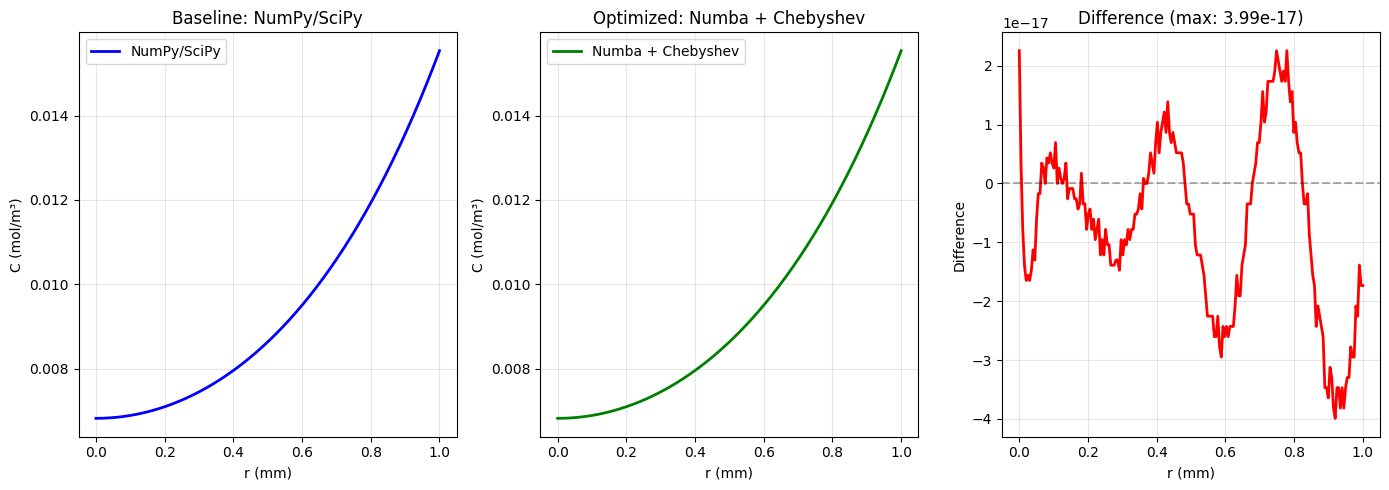

Accuracy verification:
  Max absolute difference: 3.99e-17
  Max relative error: 2.57e-15


In [26]:
# Visualize comparison between original and optimized
r_plot = np.linspace(0, R, 200)
C_baseline = steady_diffusion_cylinder(r_plot, R, L_diff, D, k_s, C_s)
C_optimized = steady_diffusion_cylinder_jit(r_plot, R, L_diff, D, k_s, C_s)

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(r_plot * 1e3, C_baseline, 'b-', linewidth=2, label='NumPy/SciPy')
plt.xlabel("r (mm)")
plt.ylabel("C (mol/m³)")
plt.title("Baseline: NumPy/SciPy")
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(r_plot * 1e3, C_optimized, 'g-', linewidth=2, label='Numba + Chebyshev')
plt.xlabel("r (mm)")
plt.ylabel("C (mol/m³)")
plt.title("Optimized: Numba + Chebyshev")
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 3, 3)
diff = C_baseline - C_optimized
plt.plot(r_plot * 1e3, diff, 'r-', linewidth=2)
plt.xlabel("r (mm)")
plt.ylabel("Difference")
plt.title(f"Difference (max: {np.abs(diff).max():.2e})")
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Accuracy verification:")
print(f"  Max absolute difference: {np.abs(diff).max():.2e}")
print(f"  Max relative error: {np.abs(diff).max() / C_baseline.max():.2e}")

## Performance Analysis Framework

Use this section to compare all implementations and analyze the results.

🏆 Performance Comparison Results:


,Method,Time (s),Throughput (M evals/s),Speedup,Relative Performance
0,NumPy/SciPy (baseline),0.322817,30.977350,1.000000,1.00x
1,Numba + Chebyshev,0.072947,137.086066,4.425364,4.43x


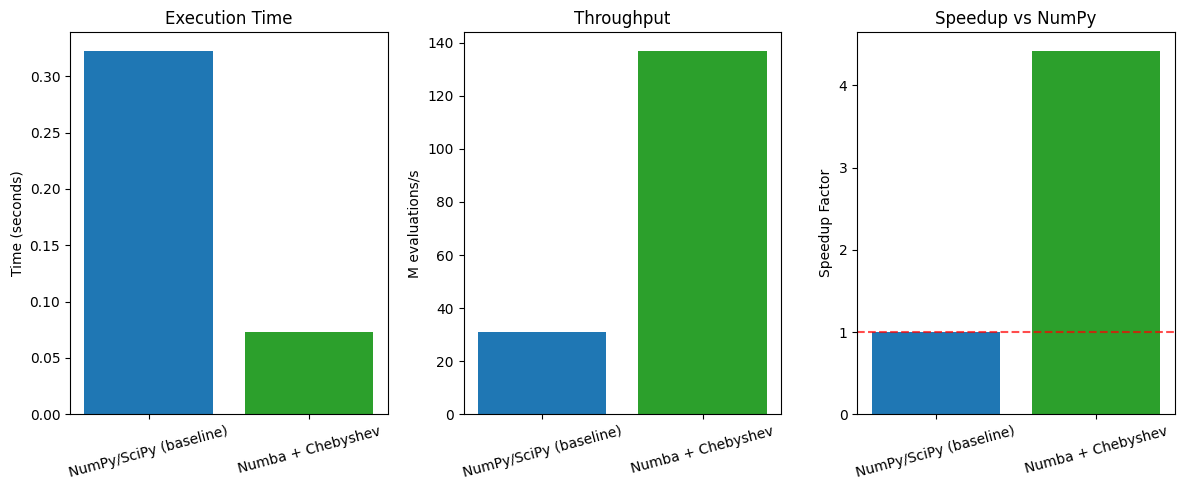

In [27]:
# Performance comparison framework
def compare_implementations():
    """
    Run all implementations and create a performance comparison table
    """
    methods = []
    times = []
    speedups = []
    
    # Original NumPy/SciPy baseline (already computed)
    baseline_time = elapsed  # from earlier cell
    methods.append("NumPy/SciPy (baseline)")
    times.append(baseline_time)
    speedups.append(1.0)
    
    # Add optimized implementation
    if 'steady_diffusion_cylinder_jit' in globals():
        start = time.perf_counter()
        C_test = steady_diffusion_cylinder_jit(r_array, R, L_diff, D, k_s, C_s)
        elapsed_test = time.perf_counter() - start
        methods.append("Numba + Chebyshev")
        times.append(elapsed_test)
        speedups.append(baseline_time / elapsed_test)
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'Method': methods,
        'Time (s)': times,
        'Throughput (M evals/s)': [n_points/t/1e6 for t in times],
        'Speedup': speedups,
        'Relative Performance': [f"{s:.2f}x" for s in speedups]
    })
    
    print("🏆 Performance Comparison Results:")
    display(comparison_df)
    
    # Visualization
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 3, 1)
    plt.bar(methods, times, color=['#1f77b4', '#2ca02c'])
    plt.title("Execution Time")
    plt.ylabel("Time (seconds)")
    plt.xticks(rotation=15)
    
    plt.subplot(1, 3, 2)
    throughputs = [n_points/t/1e6 for t in times]
    plt.bar(methods, throughputs, color=['#1f77b4', '#2ca02c'])
    plt.title("Throughput")
    plt.ylabel("M evaluations/s")
    plt.xticks(rotation=15)
    
    plt.subplot(1, 3, 3)
    plt.bar(methods, speedups, color=['#1f77b4', '#2ca02c'])
    plt.title("Speedup vs NumPy")
    plt.ylabel("Speedup Factor")
    plt.xticks(rotation=15)
    plt.axhline(y=1, color='r', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

# Run comparison
results = compare_implementations()